In [1]:
import importlib
import time
import os
import pickle
import glob
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
tune_name = 'fine_obs_R'

save_dir = 'fine_time'

home = os.path.expanduser("~")

save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)

tune_dir = os.path.join(save_dir, tune_name)

stdrd_dir = os.path.join(tune_dir, 'stdrd_loc')
smooth_dir = os.path.join(tune_dir, 'smooth_loc')

this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 'Z0_ens.npy')
Z0ens = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)


this_path = os.path.join(save_dir, 'run_vars.pkl')
with open(this_path, mode='rb') as f:
    run_vars = pickle.load(f)

In [6]:
for key, value in run_vars.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

Nz = 960
K = 32
I = 12
F = 15.0
b = 10.0
c = 2.5
alpha = 0.12414383561643835
beta = 0.013746194824961947
coarse = 8
Nez = 20
Nex = 500
dt_gt = 0.000625
Tgt = 25.0


In [10]:
# if not os.path.exists(tune_dir):
#     os.mkdir(tune_dir)

# dt_trial_rk = 0.05/24
# dt_kf = 0.05
# dt_save = None
# Tkf = Tgt/5     #### Change this
# Tspin_index = 500
# Tspin = dt_kf * Tspin_index

# alpha_range = np.array([0, 0.01, 0.02, 0.04, 0.08], dtype='float')
# loc_range = np.array([5, 10, 15, 20, 30, 40, 50, 60], dtype='float')


# R_sd = 2
# everyH = 24
# Hz = np.eye(Nz)[::everyH]
# Ny = Hz.shape[0]
# Rz = np.eye(Ny) * R_sd**2

# fine_obs_dict = {'dt_trial_rk': dt_trial_rk,
#                  'dt_kf': dt_kf,
#                  'dt_save': dt_save,
#                  'Tkf': Tkf,
#                  'Tspin': Tspin,
#                  'alpha_range': alpha_range,
#                  'loc_range': loc_range,
#                  'R_sd': R_sd,
#                  'Hz': Hz,
#                  'Rz': Rz}

this_path = os.path.join(tune_dir, 'KF_dict.pkl')
with open(this_path, mode='rb') as f:
    fine_obs_dict = pickle.load(f)

for key, value in fine_obs_dict.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')
    
# Ny = Hz.shape[0]
# Rz = np.eye(Ny)

del alpha_range, loc_range

Tspin_index = int(Tspin/dt_kf)

dt_trial_rk = 0.000625
dt_kf = 0.005
dt_save = None
Tkf = 5.0
Tspin = 2.5
alpha_range = [0.   0.04 0.08 0.12]
loc_range = [  2.   4.   6.   8.  10.  15.  30.  60.  90. 120.]
R_sd = 0.3
everyH = 1
Hz = [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Rz = [[0.09       0.05432795 0.05390728 ... 0.05400951 0.05390728 0.05432795]
 [0.05432795 0.09       0.05432795 ... 0.053933   0.05400951 0.05390728]
 [0.05390728 0.05432795 0.09       ... 0.0539397  0.053933   0.05400951]
 ...
 [0.05400951 0.053933   0.0539397  ... 0.09       0.05432795 0.05390728]
 [0.05390728 0.05400951 0.053933   ... 0.05432795 0.09       0.05432795]
 [0.05432795 0.05390728 0.05400951 ... 0.05390728 0.05432795 0.09      ]]


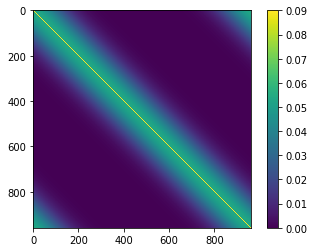

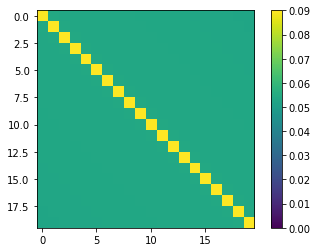

In [13]:
imshow(Rz, vmin=0)
imshow(Rz[:20, :20], vmin=0)

In [14]:
Nobs = int(Tkf/dt_kf) + 1
t_kf = np.linspace(0, Tkf, Nobs)

Ngt = int(Tgt/dt_gt) + 1
t_gt = np.linspace(0, Tgt, Ngt)
index_Tkf = int(Tkf/dt_gt) + 1

every_t = int(dt_kf/dt_gt)

if not np.allclose(t_kf, t_gt[0:index_Tkf:every_t]):
    print('They do not match')

In [15]:
Zloc = np.arange(Nz)

Zgt_ts = xr.DataArray(Zgt[:, 0:index_Tkf:every_t],
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})
Zobs_ts = Zgt[::everyH, 0:index_Tkf:every_t]
Zobs_ts = xr.DataArray(Zobs_ts,
                       dims=('loc', 'time'),
                       coords={'loc': Zloc[::everyH],
                               'time': t_kf})
del Zgt

In [16]:
search_path = os.path.join(smooth_dir, 'inf_????_smooth_????_floc_????_cloc_????*')
smooth_dirs = glob.glob(search_path)
smooth_dirs.sort()

smooth_rmse_f = []
smooth_rmse_a = []
smooth_std_f = []
smooth_std_a = []

smooth_alpha = []
smooth_cloc = []
smooth_floc = []
smooth_smooth = []
for this_dir in smooth_dirs:
    print(os.path.split(this_dir)[1])
    
    this_path = os.path.join(this_dir, 'alpha.npy')
    smooth_alpha.append(np.load(this_path).item())
    
    this_path = os.path.join(this_dir, 'rho0c.npy')
    smooth_cloc.append(np.load(this_path).item())
    
    this_path = os.path.join(this_dir, 'rho0f.npy')
    smooth_floc.append(np.load(this_path).item())
    
    this_path = os.path.join(this_dir, 'smooth.npy')
    smooth_smooth.append(np.load(this_path, allow_pickle=True).item())
    
    this_path = os.path.join(this_dir, 'mu_f.nc')
    temp_mu_f = xr.open_dataarray(this_path)

    this_path = os.path.join(this_dir, 'mu_a.nc')
    temp_mu_a = xr.open_dataarray(this_path)
    
    
    smooth_rmse_f.append(np.sqrt(
        ((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                  .isel(time=slice(Tspin_index, None)).mean().item())
    smooth_rmse_a.append(np.sqrt(
        ((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                  .isel(time=slice(Tspin_index, None)).mean().item())
    
    this_path = os.path.join(this_dir, 'std_f.nc')
    temp_std_f = xr.open_dataarray(this_path)

    this_path = os.path.join(this_dir, 'std_a.nc')
    temp_std_a = xr.open_dataarray(this_path)
    
    smooth_std_f.append(np.sqrt((temp_std_f**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean().item())
    smooth_std_a.append(np.sqrt((temp_std_a**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean().item())
smooth_alpha = np.array(smooth_alpha)
smooth_cloc = np.array(smooth_cloc)
smooth_floc = np.array(smooth_floc)
smooth_smooth = np.array(smooth_smooth)

smooth_rmse_f = np.array(smooth_rmse_f)
smooth_rmse_a = np.array(smooth_rmse_a)

inf_0000_smooth_0000_floc_0000_cloc_0000
inf_0000_smooth_0000_floc_0000_cloc_0001
inf_0000_smooth_0000_floc_0000_cloc_0002
inf_0000_smooth_0000_floc_0000_cloc_0003
inf_0000_smooth_0000_floc_0001_cloc_0000
inf_0000_smooth_0000_floc_0001_cloc_0001
inf_0000_smooth_0000_floc_0001_cloc_0002
inf_0000_smooth_0000_floc_0001_cloc_0003
inf_0000_smooth_0000_floc_0002_cloc_0000
inf_0000_smooth_0000_floc_0002_cloc_0001
inf_0000_smooth_0000_floc_0002_cloc_0002
inf_0000_smooth_0000_floc_0002_cloc_0003
inf_0000_smooth_0000_floc_0003_cloc_0000
inf_0000_smooth_0000_floc_0003_cloc_0001
inf_0000_smooth_0000_floc_0003_cloc_0002
inf_0000_smooth_0000_floc_0003_cloc_0003
inf_0000_smooth_0000_floc_0004_cloc_0000
inf_0000_smooth_0000_floc_0004_cloc_0001
inf_0000_smooth_0000_floc_0004_cloc_0002
inf_0000_smooth_0000_floc_0004_cloc_0003
inf_0000_smooth_0001_floc_0000_cloc_0000
inf_0000_smooth_0001_floc_0000_cloc_0001
inf_0000_smooth_0001_floc_0000_cloc_0002
inf_0000_smooth_0001_floc_0000_cloc_0003
inf_0000_smooth_

In [17]:
# smooth_alpha = smooth_alpha[:-1]
# smooth_cloc = smooth_cloc[:-1]
# smooth_floc = smooth_floc[:-1]
# smooth_smooth = smooth_smooth[:-1]

# smooth_alpha = np.array(smooth_alpha)
# smooth_cloc = np.array(smooth_cloc)
# smooth_floc = np.array(smooth_floc)
# smooth_smooth = np.array(smooth_smooth)

# smooth_rmse_f = np.array(smooth_rmse_f)
# smooth_rmse_a = np.array(smooth_rmse_a)

In [18]:
search_path = os.path.join(stdrd_dir, 'inf_????_loc_????')
stdrd_dirs = glob.glob(search_path)
stdrd_dirs.sort()

stdrd_rmse_f = []
stdrd_rmse_a = []
stdrd_std_f = []
stdrd_std_a = []

stdrd_alpha = []
stdrd_loc = []
for this_dir in stdrd_dirs:
    print(os.path.split(this_dir)[1])
    
    this_path = os.path.join(this_dir, 'alpha.npy')
    stdrd_alpha.append(np.load(this_path).item())
    
    this_path = os.path.join(this_dir, 'rho0z.npy')
    stdrd_loc.append(np.load(this_path).item())
    
    this_path = os.path.join(this_dir, 'mu_f.nc')
    temp_mu_f = xr.open_dataarray(this_path)

    this_path = os.path.join(this_dir, 'mu_a.nc')
    temp_mu_a = xr.open_dataarray(this_path)
    
    stdrd_rmse_f.append(np.sqrt(
        ((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                  .isel(time=slice(Tspin_index, None)).mean().item())
    stdrd_rmse_a.append(np.sqrt(
        ((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                  .isel(time=slice(Tspin_index, None)).mean().item())
    
    this_path = os.path.join(this_dir, 'std_f.nc')
    temp_std_f = xr.open_dataarray(this_path)

    this_path = os.path.join(this_dir, 'std_a.nc')
    temp_std_a = xr.open_dataarray(this_path)
    
    stdrd_std_f.append(np.sqrt((temp_std_f**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean().item())
    stdrd_std_a.append(np.sqrt((temp_std_a**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean().item())

stdrd_alpha = np.array(stdrd_alpha)
stdrd_loc = np.array(stdrd_loc)

stdrd_rmse_f = np.array(stdrd_rmse_f)
stdrd_rmse_a = np.array(stdrd_rmse_a)

inf_0000_loc_0000
inf_0000_loc_0001
inf_0000_loc_0002
inf_0000_loc_0003
inf_0000_loc_0004
inf_0000_loc_0005
inf_0000_loc_0006
inf_0000_loc_0007
inf_0000_loc_0008
inf_0000_loc_0009
inf_0001_loc_0000
inf_0001_loc_0001
inf_0001_loc_0002
inf_0001_loc_0003
inf_0001_loc_0004
inf_0001_loc_0005
inf_0001_loc_0006
inf_0001_loc_0007
inf_0001_loc_0008
inf_0001_loc_0009
inf_0002_loc_0000
inf_0002_loc_0001
inf_0002_loc_0002
inf_0002_loc_0003
inf_0002_loc_0004
inf_0002_loc_0005
inf_0002_loc_0006
inf_0002_loc_0007
inf_0002_loc_0008
inf_0002_loc_0009
inf_0003_loc_0000
inf_0003_loc_0001
inf_0003_loc_0002
inf_0003_loc_0003
inf_0003_loc_0004
inf_0003_loc_0005
inf_0003_loc_0006
inf_0003_loc_0007
inf_0003_loc_0008
inf_0003_loc_0009


In [19]:
# stdrd_alpha = stdrd_alpha[:-1]
# stdrd_loc = stdrd_loc[:-1]

# stdrd_alpha = np.array(stdrd_alpha)
# stdrd_loc = np.array(stdrd_loc)

# stdrd_rmse_f = np.array(stdrd_rmse_f)
# stdrd_rmse_a = np.array(stdrd_rmse_a)

In [20]:
smooth_index_f = np.argmin(smooth_rmse_f)
smooth_index_a = np.argmin(smooth_rmse_a)

stdrd_index_f = np.argmin(stdrd_rmse_f)
stdrd_index_a = np.argmin(stdrd_rmse_a)

print('Smoothing method')
print(f'Min forecast rmse of: {smooth_rmse_f[smooth_index_f]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_f]}')
print(f'fine loc: {smooth_floc[smooth_index_f]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_f]}')
print(f'alpha: {smooth_alpha[smooth_index_f]}')
print()
print(f'Min anlysis rmse of: {smooth_rmse_a[smooth_index_a]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_a]}')
print(f'fine loc: {smooth_floc[smooth_index_a]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_a]}')
print(f'alpha: {smooth_alpha[smooth_index_a]}')

print()
print('Standard method')
print(f'Min forecast rmse of: {stdrd_rmse_f[stdrd_index_f]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_f]}')
print(f'alpha: {stdrd_alpha[stdrd_index_f]}')
print()
print(f'Min anlysis rmse of: {stdrd_rmse_a[stdrd_index_a]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_a]}')
print(f'alpha: {stdrd_alpha[stdrd_index_a]}')

sm_f = smooth_rmse_f[smooth_index_f]
sm_a = smooth_rmse_a[smooth_index_a]

stdrd_f = stdrd_rmse_f[stdrd_index_f]
stdrd_a = stdrd_rmse_a[stdrd_index_a]
print()
print(f'This is a {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}% improvement for forecasts')
print(f'This is a {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}% improvement for analysis')

Smoothing method
Min forecast rmse of: 0.01085
With coarse loc: 80
fine loc: 8
smoothing dist: 16
alpha: 0.06

Min anlysis rmse of: 0.01013
With coarse loc: 80
fine loc: 8
smoothing dist: 16
alpha: 0.06

Standard method
Min forecast rmse of: 0.04466
With loc: 10.0
alpha: 0.08

Min anlysis rmse of: 0.04318
With loc: 10.0
alpha: 0.08

This is a 75.71% improvement for forecasts
This is a 76.54% improvement for analysis


In [21]:
sm_f = smooth_rmse_f[smooth_index_f]
sm_a = smooth_rmse_a[smooth_index_f]

stdrd_f = stdrd_rmse_f[stdrd_index_f]
stdrd_a = stdrd_rmse_a[stdrd_index_f]
print()
print(f'This is a {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}% improvement for forecasts')
print(f'This is a {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}% improvement for analysis')


This is a 75.71% improvement for forecasts
This is a 76.54% improvement for analysis


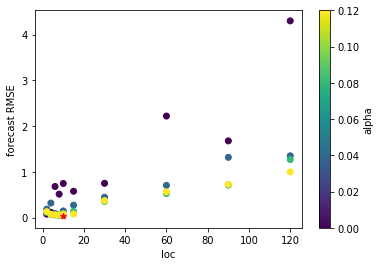

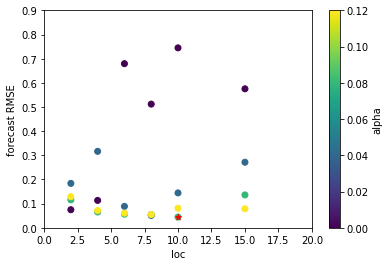

In [22]:
plt.figure()
im = plt.scatter(stdrd_loc, stdrd_rmse_f, c=stdrd_alpha)
cbar = plt.colorbar(im)
plt.scatter(stdrd_loc[stdrd_index_f],
            stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('forecast RMSE')
plt.xlabel('loc')
cbar.set_label('alpha')

plt.figure()
im = plt.scatter(stdrd_loc, stdrd_rmse_f, c=stdrd_alpha)
cbar = plt.colorbar(im)
plt.scatter(stdrd_loc[stdrd_index_f],
            stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.xlim([0, 20])
plt.ylim([0, 0.9])
plt.ylabel('forecast RMSE')
plt.xlabel('loc')
cbar.set_label('alpha')

In [23]:
%matplotlib inline

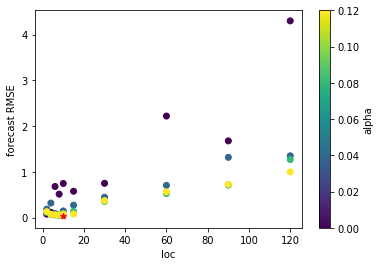

In [24]:
plt.figure()
im = plt.scatter(stdrd_loc, stdrd_rmse_f, c=stdrd_alpha)
cbar = plt.colorbar(im)
plt.scatter(stdrd_loc[stdrd_index_f],
            stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('forecast RMSE')
plt.xlabel('loc')
cbar.set_label('alpha')

In [25]:
smooth_floc

array([ 2,  2,  2,  2,  4,  4,  4,  4,  8,  8,  8,  8, 16, 16, 16, 16, 32,
       32, 32, 32,  2,  2,  2,  2,  4,  4,  4,  4,  8,  8,  8,  8, 16, 16,
       16, 16, 32, 32, 32, 32,  2,  2,  2,  2,  4,  4,  4,  4,  8,  8,  8,
        8, 16, 16, 16, 16, 32, 32, 32, 32,  2,  2,  2,  2,  4,  4,  4,  4,
        8,  8,  8,  8, 16, 16, 16, 16, 32, 32, 32, 32])

In [34]:
%matplotlib inline

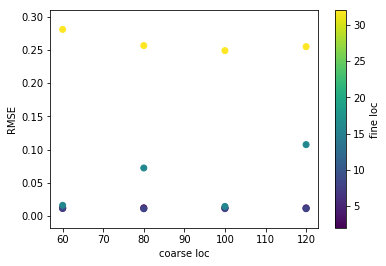

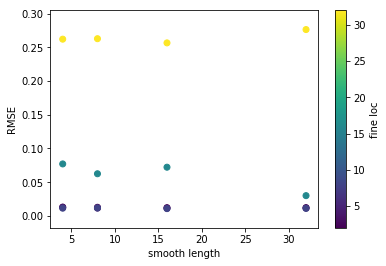

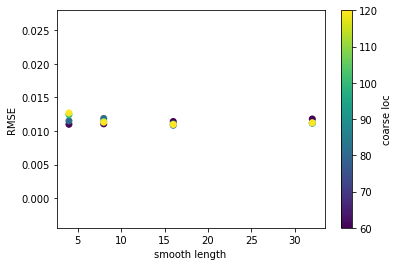

In [36]:
# smooth_mask = smooth_smooth == smooth_smooth[smooth_index_f]
cloc_mask = smooth_cloc == smooth_cloc[smooth_index_f]
floc_mask = smooth_floc == smooth_floc[smooth_index_f]

plt.figure()
im = plt.scatter(smooth_cloc[smooth_mask],
                 smooth_rmse_f[smooth_mask],
                 c=smooth_floc[smooth_mask])
cbar = plt.colorbar(im)
plt.ylabel('RMSE')
plt.xlabel('coarse loc')
cbar.set_label('fine loc')

plt.figure()
im = plt.scatter(smooth_smooth[cloc_mask],
                 smooth_rmse_f[cloc_mask],
                 c=smooth_floc[cloc_mask])
cbar = plt.colorbar(im)
# plt.scatter(stdrd_loc[stdrd_index_f],
#             stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('RMSE')
plt.xlabel('smooth length')
cbar.set_label('fine loc')

plt.figure()
im = plt.scatter(smooth_smooth[floc_mask],
                 smooth_rmse_f[floc_mask],
                 c=smooth_cloc[floc_mask])
cbar = plt.colorbar(im)
# plt.scatter(stdrd_loc[stdrd_index_f],
#             stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('RMSE')
plt.xlabel('smooth length')
cbar.set_label('coarse loc')